###  UltraSonicSensorAnalysis Jupyter notebook - Keras version


#### Our goal is to predict the reflected (Echo) signal using other, more readily available, transducer parameters. 
#### We will use Frequency, Ring-down, and Excitation voltage to predict Echo signal amplitude. 

In [6]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

#import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import plot_model


### Read in the data and create the training and test data sets

In [7]:
# There are up to 10 measurements for each Die ID, and we need to keep these 10 measurements together so the 
# training and test sets have no cross-talk or "contamination".  In other words, 10 measurements for a given
# Die ID will all be either training or test measurements. 

# Here is the strategy:
# 1) Get all the unique Die IDs
# 2) Split the Die IDs into train IDs and test IDs
# 3) Create a test data frame from the test IDs and a train data frame from the train IDs

# First, read in the data from the "data" subfolder:
df = pd.read_csv('../data/test_data.csv')

# Here are all the unique Die IDs
die_ids = np.unique(df['Die ID'])
print("Unique Die IDs found:", len(die_ids))

# Here is the training fraction
train_frac = 0.75

# Now create a random list of the Die IDs to be used for training
train_ids = np.random.choice(die_ids, size=int(train_frac*len(die_ids)), replace=False)
print("Number of training Die IDs:", len(train_ids))

# Now here are the Die IDs to be used for testing - just get what wasn't used for training
test_ids = np.setdiff1d(die_ids, train_ids)
print("Number of testing Die IDs:", len(test_ids))
print()

# Confirm no training Die IDs are intermixed with testing Die IDs:
if (np.intersect1d(train_ids, test_ids, assume_unique=False, return_indices=False).size > 0):
    print("Testing and training Die IDs appear to be intermixed!!")
else:
    print("No crosstalk between training and testing Die IDs found.")

    
# Here, create the test and train data frames based on the Die IDs
test_df = pd.DataFrame()
train_df = pd.DataFrame()
junk = pd.DataFrame()

for tstid in test_ids:
    junk = df[ df['Die ID'] == tstid  ]
    #test_df = test_df.append(junk)
    test_df = pd.concat([test_df, junk], axis=0)

for trainid in train_ids:
    junk = df[ df['Die ID'] == trainid  ]
    #train_df = train_df.append(junk)
    train_df = pd.concat([train_df, junk], axis=0)
    
#print(test_df.shape, train_df.shape)
#print("Total number of rows:", train_df.shape[0] + test_df.shape[0])


# Split the train and test data into features (X) and labels (y):
X_train = train_df[['Frequency', 'Ring-down','Excitation']]
y_train = train_df['Echo']

X_test = test_df[['Frequency', 'Ring-down','Excitation']]
y_test = test_df['Echo']


# Not too critical in this case, but scale the features
scaler = MinMaxScaler()

X_train= scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Unique Die IDs found: 712
Number of training Die IDs: 534
Number of testing Die IDs: 178

No crosstalk between training and testing Die IDs found.


###  Define a very simple Keras neural network model with relu activation

#### Remember the input shape is the number of features

In [13]:
model = Sequential()

model.add(Dense(units=6, input_shape=(X_test.shape[1],), activation='relu'))
model.add(Dense(9, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam',loss='mse')

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 6)                 24        
                                                                 
 dense_7 (Dense)             (None, 9)                 63        
                                                                 
 dense_8 (Dense)             (None, 1)                 10        
                                                                 
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________


### Train the model here

#### By default, we suppress output and shuffle the data. No need for GPU; the default model only takes several seconds to run. 

In [14]:
num_epochs = 250  # 250 works pretty well - may change if you change the model though!
batch_size = 64  # 64 works pretty well - may change if you change the model though!

model.fit(x=X_train,y=y_train.values,
          validation_data=(X_test,y_test.values),
          batch_size=batch_size, epochs=num_epochs, shuffle=True, verbose=0) # Output suppressed here

# Retain the model history
model_history = model.history.history

### Calculate the MSE and show the loss versus the epoch number

55/55 [==============================] - 0s 847us/step


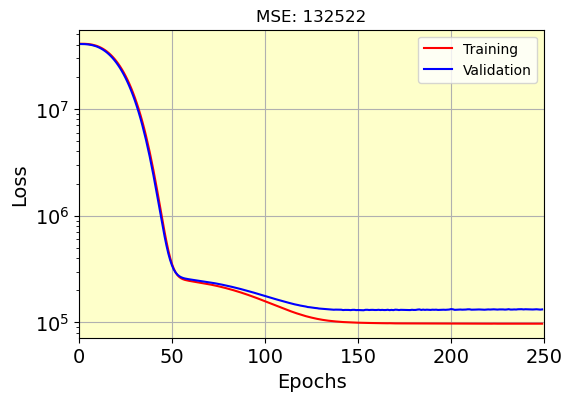

In [15]:
# Predict using the test features and compare to the actual
predictions = model.predict(X_test)
mse = round(mean_squared_error(y_test, predictions) )

save_fig = False

fig = plt.figure(figsize=(6, 4))
fig.add_subplot(111)

# Plot the model loss over the training epochs
losses = pd.DataFrame(model_history)
plt.semilogy(losses['loss'], 'r-', label='Training')
plt.semilogy(losses['val_loss'], 'b-', label='Validation')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title(f'MSE: {np.round(mse, 1)}')
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)
ax = plt.gca()

ax.set_facecolor('#feffcA')
plt.grid()
plt.xlim(0, num_epochs)
plt.legend();


if save_fig:
    fig = plt.gcf()
    fig_name = "Loss"
    fig.savefig("All_data" + fig_name)

### Finally, plot the predicted versus the ground truth Echo signal values as well as the best linear fit

55/55 [==============================] - 0s 802us/step
Slope: 0.885    Offset: 688.1


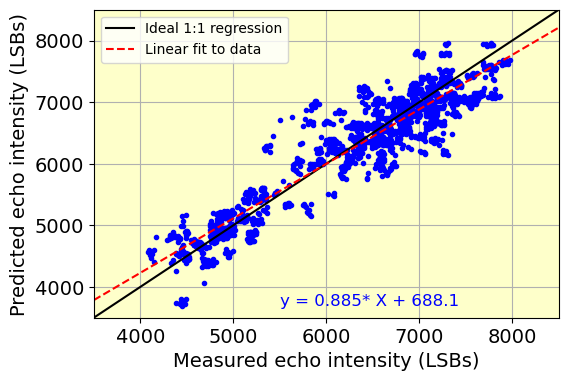

In [16]:
save_fig = False

fig = plt.figure(figsize=(6, 4))
fig.add_subplot(111)

the_start = 3500
the_end = 8500
predictions = model.predict(X_test)
predictions = predictions.reshape(-1, 1)

# Our predictions of the amplitude versus measured:
plt.plot(y_test, predictions, 'b.')

# Perfect prediction - a solid black line
plt.plot([the_start, the_end], [the_start, the_end],'k-', label="Ideal 1:1 regression")
plt.xlim(the_start, the_end)
plt.ylim(the_start, the_end)
ax = plt.gca()
ax.set_facecolor('#feffcA')
plt.grid()

plt.xlabel('Measured echo intensity (LSBs)', fontsize=14)
plt.ylabel('Predicted echo intensity (LSBs)', fontsize=14)

plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)

lin_reg = LinearRegression()
lin_reg.fit(np.array(y_test).reshape(-1, 1), predictions)

slope = np.round(lin_reg.coef_[0][0], 3)
intercept = np.round(lin_reg.intercept_[0], 1)

# Here are intercept and slope of predicted vs. actual amplitude values
print("Slope:", slope, "   Offset:",intercept)

# Plot linear fit of the predicted amplitude versus measured:
plt.plot([the_start, the_end],
         [the_start*lin_reg.coef_[0][0] + lin_reg.intercept_[0] , 
          the_end*lin_reg.coef_[0][0] + lin_reg.intercept_[0] ], 'r--', label="Linear fit to data")

# Show the best linear fit slope and intercept:
plt.text(the_start + 2000, the_start + 200, 'y = '+str(slope)+"* X + " + str(intercept), fontsize=12,color = (0, 0, 1));
plt.legend(loc='upper left')

if save_fig:
    fig = plt.gcf()
    fig_name = "test"
    fig.savefig("test" + fig_name)

In [17]:
# Coefficient of determination - R^2
y_train_preds = model.predict(X_train)
train_r2 = r2_score(np.array(y_train).reshape(-1, 1), y_train_preds)
test_r2 = r2_score(np.array(y_test).reshape(-1, 1), predictions)

print(train_r2, test_r2)

162/162 [==============================] - 0s 781us/step
0.9061367148473181 0.8591255177281425
